In [1]:
#%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

In [2]:
#%pip install -qU "langchain[google-genai]"
#%pip install beautifulsoup4


In [3]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Get API key from environment
google_api_key = os.getenv("GOOGLE_API_KEY")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

c:\Users\ASUS\anaconda3\envs\testone\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

In [5]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [6]:
#%pip install -U langchain
#%pip install -U langchain langchain-core langchain-community



In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43047


In [8]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [10]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['5e1593c2-d00b-4870-8703-e5a2b153402a', 'd5954b41-7e96-4727-a782-fcb2e4867165', 'fc105861-8ee0-4c88-acb2-5e2283c4fbc9']


In [15]:
# Install the correct package for hub functionality
%pip install -U langchainhub

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Simple solution: Create the RAG prompt manually (recommended approach)
from langchain_core.prompts import ChatPromptTemplate

# Create the standard RAG prompt template
prompt = ChatPromptTemplate.from_template("""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Question: {question}

Context: {context}

Answer:""")

# Test the prompt
example_messages = prompt.invoke(
    {"context": "This is sample context about AI agents and their components.", 
     "question": "What are the main components of an AI agent?"}
).to_messages()

print("✅ RAG prompt template created successfully!")
print(f"Type: {type(prompt)}")
print(f"Number of template variables: {len(prompt.input_variables)}")
print(f"Template variables: {prompt.input_variables}")
print(f"\nExample message content:")
print(example_messages[0].content)

✅ RAG prompt template created successfully!
Type: <class 'langchain_core.prompts.chat.ChatPromptTemplate'>
Number of template variables: 2
Template variables: ['context', 'question']

Example message content:
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Question: What are the main components of an AI agent?

Context: This is sample context about AI agents and their components.

Answer:


In [21]:
# Complete RAG system test
def ask_question(question):
    """Ask a question using the RAG system"""
    # Retrieve relevant documents
    retrieved_docs = vector_store.similarity_search(question, k=3)
    
    # Combine document content
    context = "\n\n".join(doc.page_content for doc in retrieved_docs)
    
    # Generate response using the prompt
    messages = prompt.invoke({"question": question, "context": context})
    response = llm.invoke(messages)
    
    return {
        "question": question,
        "answer": response.content,
        "num_docs": len(retrieved_docs),
        "sources": [doc.metadata.get('source', 'Unknown') for doc in retrieved_docs]
    }

# Test the complete RAG system
test_question = "What are the key components of an AI agent?"
result = ask_question(test_question)

print(f"Question: {result['question']}")
print(f"Answer: {result['answer']}")
print(f"\nRetrieved {result['num_docs']} relevant documents")
print(f"Sources: {set(result['sources'])}")  # Use set to remove duplicates

Question: What are the key components of an AI agent?
Answer: Based on the provided context, a key component of an AI agent is Planning. This involves understanding the steps required for a complicated task and planning ahead. Planning incorporates task decomposition techniques such as Chain of Thought and Tree of Thoughts to break down complex problems into smaller, manageable steps.

Retrieved 3 relevant documents
Sources: {'https://lilianweng.github.io/posts/2023-06-23-agent/'}


In [22]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [23]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [24]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

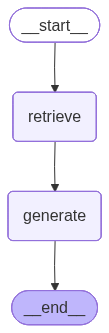

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='593cea41-cfb6-4082-b878-ca1e140bb28d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availab

In [27]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

Task decomposition is a technique used to break down complex tasks into smaller, simpler, and more manageable steps. This process helps an agent plan ahead for complicated tasks and enhances model performance. It can be achieved through methods like LLM prompting, task-specific instructions|, or human inputs.||

In [28]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [29]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [30]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [31]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [32]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

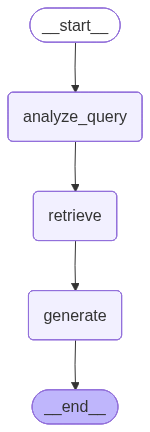

In [33]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='99d3c191-071a-45a1-b835-af19670e2695', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 38621, 'section': 'end'}, page_content='are imported by that file, and so on.\\nFollow a language and framework appropriate best practice file naming convention.\\nMake sure that files contain all imports, types etc. The code should be fully functional. Make sure that code in different files are compatible with each other.\\nBefore you finish, double check that all parts of the architecture is present in the files.\\n"'), Document(id='d6870c79-77bd-46e7-b15f-ec63d5f681e2', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 34990, 'section': 'end'}, page_content='Conversatin samples:\n[\n  {\n    "role": "system",'), Document(id='33ce76f4-b03e-4e2b-bcca-746c25b4aeac', metadata={'sourc